In [1]:
import os
from os.path import isdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

D:\Miniconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
words = [word for word in os.listdir('data/train')]
command_words = sorted(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'])


def load_word(fold, word):   
    X = np.load('data/{}/{}/mfcc.npy'.format(fold, word))
    y = np.full(shape=X.shape[0],
                fill_value=word if word in command_words else 'unknown')
    return X, y

def get_fold_data(fold, words=words):
    """
    Reads in mfcc data  and labels for entire fold
    fold: 'train', 'validation', or 'test'
    words: list of words to extract
    """
    
    X_total = np.array([]).reshape(0, 20 , 32)
    y_total = np.array([])
    for word in words:
        X_word, y_word = load_word(fold, word)
        X_total = np.vstack([X_total, X_word])
        y_total = np.append(y_total, y_word)
        
    return X_total, y_total

X_train, y_train = get_fold_data('train', command_words)
X_val, y_val = get_fold_data('validation', command_words)
X_test, y_test = get_fold_data('test', command_words)

print('Number of training samples: {}'.format(len(X_train)))
print('Number of validation samples: {}'.format(len(X_val)))
print('Number of testing samples: {}'.format(len(X_test)))
print('Shape of each sample: {}'.format(X_train[0].shape))

Number of training samples: 30769
Number of validation samples: 3703
Number of testing samples: 4074
Shape of each sample: (20, 32)


In [4]:
def reformat_X(X):
    """
    Reshapes X into an 'image' of depth 1
    """
    X = X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    return X

def reformat_y(y):
    """
    Formats y into one hot encoded integers
    """
    y = LabelEncoder().fit_transform(y)
    y = to_categorical(y)
    return y

X_train_img = reformat_X(X_train)
X_val_img = reformat_X(X_val)
X_test_img = reformat_X(X_test)

y_train_hot = reformat_y(y_train)
y_val_hot = reformat_y(y_val)
y_test_hot = reformat_y(y_test)
    
print('X_train shape: {}'.format(X_train_img.shape))
print('y_train_hot shape: {}'.format(y_train_hot.shape))

X_train shape: (30769, 20, 32, 1)
y_train_hot shape: (30769, 10)


# Convolutional Neural Network

In [12]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train_img[0].shape)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train_img, y_train_hot, batch_size=128, epochs=100, verbose=1,
          validation_data=(X_val_img, y_val_hot), callbacks=[EarlyStopping(patience=3)])

Train on 30769 samples, validate on 3703 samples
Epoch 1/100
30769/30769 [==============================] - 2s 68us/step - loss: 1.6059 - acc: 0.4405 - val_loss: 1.1975 - val_acc: 0.5974
Epoch 2/100
30769/30769 [==============================] - 2s 51us/step - loss: 1.1934 - acc: 0.5875 - val_loss: 0.9427 - val_acc: 0.6813
Epoch 3/100
30769/30769 [==============================] - 2s 52us/step - loss: 1.0140 - acc: 0.6477 - val_loss: 0.7978 - val_acc: 0.7372
Epoch 4/100
30769/30769 [==============================] - 2s 50us/step - loss: 0.9053 - acc: 0.6890 - val_loss: 0.7249 - val_acc: 0.7588
Epoch 5/100
30769/30769 [==============================] - 2s 51us/step - loss: 0.8445 - acc: 0.7082 - val_loss: 0.6865 - val_acc: 0.7651
Epoch 6/100
30769/30769 [==============================] - 2s 50us/step - loss: 0.8008 - acc: 0.7210 - val_loss: 0.6526 - val_acc: 0.7823
Epoch 7/100
30769/30769 [==============================] - 2s 49us/step - loss: 0.7562 - acc: 0.7378 - val_loss: 0.6082 - v

In [14]:
score = model.evaluate(x=X_test_img, y=y_test_hot)

for name, value in zip(model.metrics_names, score):
    print(name, value)

4074/4074 [==============================] - 0s 50us/step
loss 0.5102441600127494
acc 0.8262150221205717


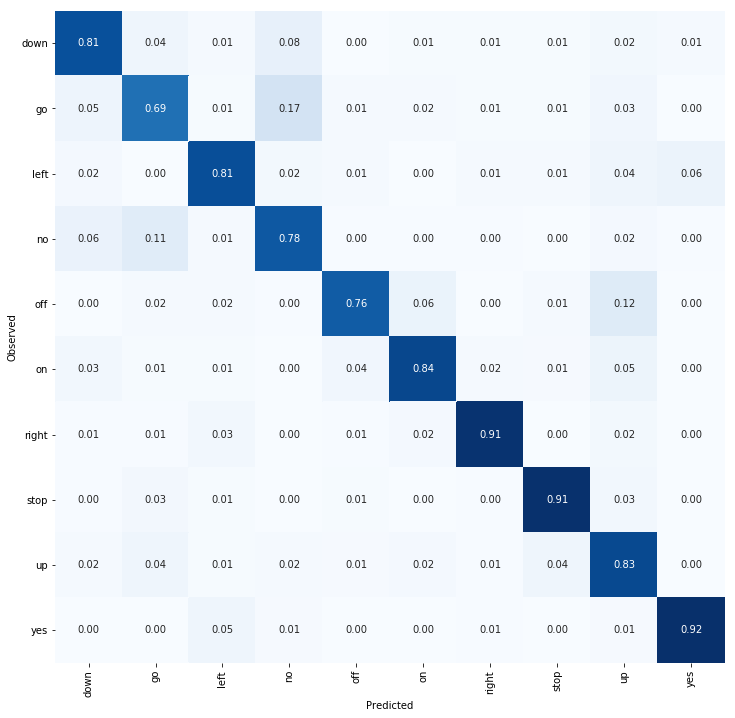

In [17]:
def plot_confusion_matrix(y_pred, y_test):
    y_pred_labels = np.array([command_words[y] for y in y_pred])
    conf_matrix = confusion_matrix(y_test, y_pred_labels)
    conf_matrix_percent = np.divide(conf_matrix.T, conf_matrix.sum(axis=1)).T
    fig, ax = plt.subplots(figsize=(12, 12))    
    sns.heatmap(conf_matrix_percent, cmap='Blues', ax=ax, annot=True, fmt='.2f', cbar=False)
    ax.set_xticklabels(command_words, rotation=90)
    ax.set_yticklabels(command_words, rotation=0)
    ax.set_ylabel('Observed')
    ax.set_xlabel('Predicted')
    plt.show()
    return conf_matrix_percent
    
y_pred = model.predict_classes(x=X_test_img)
plot_confusion_matrix(y_pred, y_test);

In [18]:
def create_summary_df(X, y, model):
    label_dict = {i: word for i, word in enumerate(command_words+['unknown'])}
    df = pd.DataFrame()
    df['y_obs_words'] = y
    try:
        df['y_pred_classes'] = model.predict_classes(X)
    except:
        X = reformat_X(X)
        df['y_pred_classes'] = model.predict_classes(X)
    df['y_pred_words'] = df['y_pred_classes'].map(label_dict)
    y_pred_proba = model.predict(X)
    df['max_confidences'] = y_pred_proba.max(axis=1)
    
    def classify_labels(row):
        if row['y_obs_words'] == 'unknown':
            return 'word not in training set'
        elif row['y_obs_words'] == row['y_pred_words']:
            return 'correct'
        else:
            return 'misclassified'
        
    df['labels'] = df.apply(classify_labels, axis=1)
    return df

def plot_hist(df, ax, color, ylabel, xlabel=False, title=False):
        hist = df[['labels', 'max_confidences']].hist(by='labels', color=color, ax=ax)    
        hist[0].set_ylabel(ylabel)   
        if not title:
            for ax in hist:
                ax.set_title('')
        if xlabel:
            for ax in hist:
                ax.set_xlabel('maximum classification confidence')          
        return hist
    
def plot_hist_grid(data, model, title=''):
    train_df = create_summary_df(data[0][0], data[0][1], model)
    val_df = create_summary_df(data[1][0], data[1][1], model)
    test_df = create_summary_df(data[2][0], data[2][1], model)
    
    fig, ax = plt.subplots(3, 3, figsize=(15 , 12))
    plot_hist(train_df, color='C0', title=True, ylabel='train samples', ax=ax[0])
    plot_hist(val_df, color='C1', ylabel='validation samples', ax=ax[1])
    plot_hist(test_df, color='C2', ylabel='test samples', xlabel=True, ax=ax[2])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(title)
    return ax

def plot_roc_curve(df):
    y_true = (df['labels']!='correct')

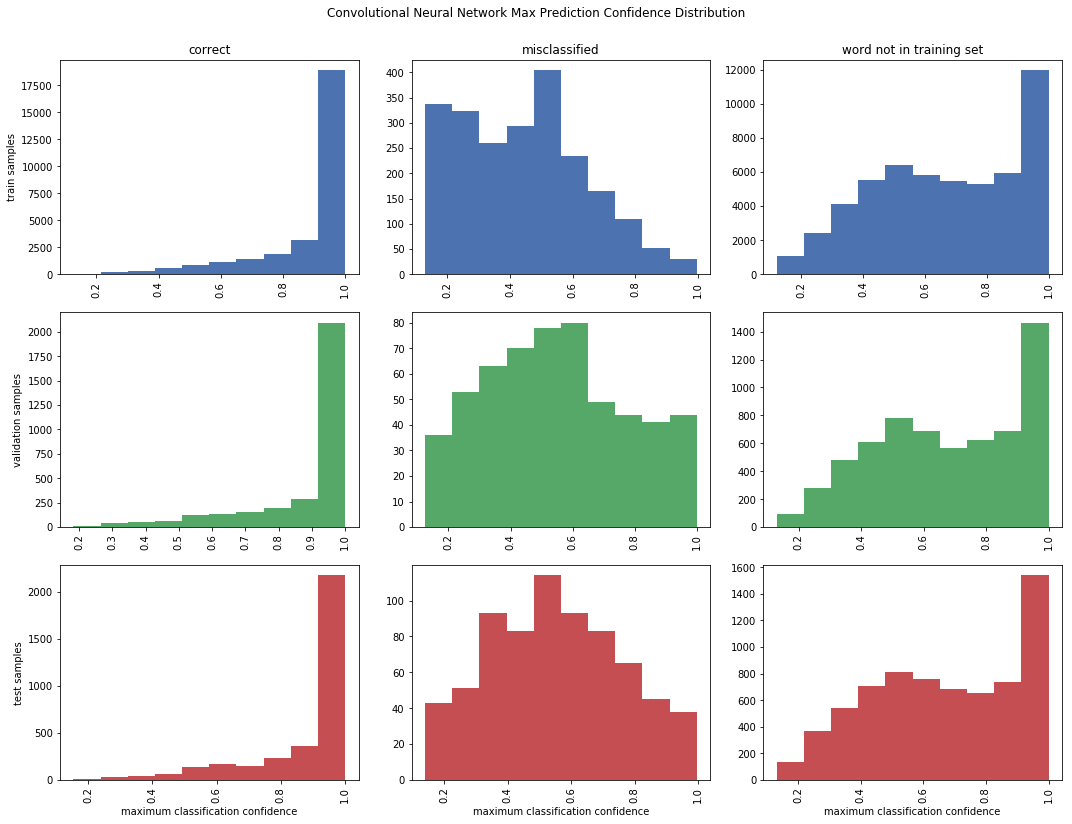

In [20]:
data = [get_fold_data(fold) for fold in ['train', 'validation', 'test']]
plot_hist_grid(data, model, title='Convolutional Neural Network Max Prediction Confidence Distribution');